In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from six.moves import cPickle as pickle
import pandas as pd
import gzip
import seaborn as sns
import string
from time import time
import nltk
from nltk.corpus import stopwords 
stops = set(stopwords.words("english"))
from urllib.request import urlretrieve
# Allows the use of display() for DataFrames
from IPython.display import display 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Exploration

In [2]:
DATASET_NAME = 'reviews_Apps_for_Android_5.json.gz'
url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/'+DATASET_NAME
last_percent_reported = None

#ur.urlretrieve(url)
print(url)

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent
                
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        #filename, _ = ur.urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print(url)
        print(filename)
        print(urlretrieve(url, str(filename)))
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

#path = "C:\Users\NITESH\Downloads\test.json.gz"
filename = "test.json.gz"
#file = str(input("Enter file path"))
#test = maybe_download(file, 95509687)
test = maybe_download(filename, 95509687)

http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Apps_for_Android_5.json.gz
Found and verified test.json.gz


We will now convert the data from "json" to a dataframe and we will pickle the file as well.


In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    data = {}
    for d in parse(path):
        data[i] = d
        i += 1
    return pd.DataFrame.from_dict(data, orient='index')

#removes extensions and adds pickle.
pickle_file_name = (filename[:-8]+'.pickle')


#loads pickle if exists, extracts and pickles if it doesn't
if os.path.exists(pickle_file_name):
    print ('Pickled file already present, loading...')
    data = pd.read_pickle(pickle_file_name)
    print ('Pickle file loaded...')
else:
    data = getDF(filename)
    data.to_pickle(pickle_file_name)

Pickled file already present, loading...
Pickle file loaded...


In [4]:
data.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3.0,Really cute,1383350400,"11 2, 2013"
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1323043200,"12 5, 2011"
2,A1SXASF6GYG96I,B004A9SDD8,Barbara Gibbs,"[0, 0]",I found this at a perfect time since my daught...,5.0,Fun game,1337558400,"05 21, 2012"
3,A2B54P9ZDYH167,B004A9SDD8,"Brooke Greenstreet ""Babylove""","[3, 4]",My 1 year old goes back to this game over and ...,5.0,We love our Monkeys!,1354752000,"12 6, 2012"
4,AFOFZDTX5UC6D,B004A9SDD8,C. Galindo,"[1, 1]",There are three different versions of the song...,5.0,This is my granddaughters favorite app on my K...,1391212800,"02 1, 2014"
5,A331GYAT4ESYI3,B004A9SDD8,Felicia,"[3, 3]",THis is just so cute and a great app for littl...,5.0,so cute,1354665600,"12 5, 2012"
6,A2YEHF8T823TDC,B004A9SDD8,Gale White Miller,"[3, 4]",I watch my great grandson 4 days a week and it...,5.0,Terrific!,1381708800,"10 14, 2013"
7,A3699WHISXX94Z,B004A9SDD8,Janie Leonard,"[0, 0]",This app is wild and crazy. Little ones love ...,5.0,Five Little Monkeys,1389484800,"01 12, 2014"
8,A2BXV49EIES2TB,B004A9SDD8,Kayla,"[3, 4]",love love love this app. I was going through d...,5.0,love but to quite,1386720000,"12 11, 2013"
9,A37HM5TMCMHJES,B004A9SDD8,kmc,"[0, 0]","Very cute, with alot of items to move about. ...",5.0,Cute,1366934400,"04 26, 2013"


In [5]:
#select the columns
df = data.iloc[:, [4,5,3]]

#split numerator and denominator
df['helpful_reviews'] = df['helpful'].apply(lambda x: x[0])
df['not_helpful_reviews'] = df['helpful'].apply(lambda x: x[1])

# delete un-needed 'helpful catagory
del df['helpful']

#Check if we have any null values
print (df.isnull().sum())

reviewText             0
overall                0
helpful_reviews        0
not_helpful_reviews    0
dtype: int64


In [6]:
df.describe()

,overall,helpful_reviews,not_helpful_reviews
count,752937.000000,752937.000000,752937.000000
mean,3.968931,3.435937,4.473125
std,1.342484,37.328951,43.688824
min,1.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,5.000000,1.000000,2.000000
max,5.000000,8116.000000,9258.000000


From the above output we observed that there are some outliers and weird numbers. Also, both the helpful_reviews and the not_helpful_reviews have a maximum variation from the data mean of over 1000 standard deviations. So, we will look at some outliers and see if they are vaild data.

In [7]:
print (df['helpful_reviews'].idxmax(axis=0, skipna=True))
print (df['not_helpful_reviews'].idxmax(axis=0, skipna=True))

510127
510127


In [8]:
df.iloc[[510127,510128]]

,reviewText,overall,helpful_reviews,not_helpful_reviews
510127,This game is the perfect sequel to Temple Run....,5.0,8116,9258
510128,this was working fine now it won't even open.....,1.0,0,2


This reviewText appears to be in good shape. Because we'll be transforming these names later, the amount in the helpful reviews and not helpful won't matter.

## Data Preprocessing

Data with fewer than ten ratings will be removed from the dataset first. There are a large number of reviews, and many of them may not have been read. As many of these reviews may be good, but do not get read and rated, our algorithm may give it some random value and make model biased.

In [9]:
#include reviews that have more than 10 helpfulness data point only
df1 = df[(df.not_helpful_reviews > 10)].copy()
df1.shape

(47932, 4)

Here we are checking if a review is helpful or not. The threshold of 'helpful_reviews' divided by 'all the reviews' was chosen as the technique. We are storing this value in helpful where if threshhold is greater than 0.5 that means reviewis helpful therefor helpful value is 0 and if threshold less than 0.5 its 0 ie. not helpful.

In [10]:
#transform Helpfulness into a binary variable with 0.50 ratio
threshold = 0.5
df1.loc[:, 'Helpful'] = np.where(df1.loc[:, 'helpful_reviews'] \
                                 / df1.loc[:, 'not_helpful_reviews'] > threshold, 1, 0)
df1.head(3)

,reviewText,overall,helpful_reviews,not_helpful_reviews,Helpful
33,"I did the 7-day trial and was impressed, but a...",3.0,15,20,1
94,"This app is great! It has a daily verse, a da...",5.0,96,107,1
284,This app simply latches on to Google maps and ...,2.0,11,23,0


We will conduct some data visualisation and counting to get a sense of the correlation and distribution.

In [11]:
#Check the balance
print ('Count:')
display(df1.groupby('Helpful').count())

Count:


,reviewText,overall,helpful_reviews,not_helpful_reviews
Helpful,,,,
0,6210,6210,6210,6210
1,41722,41722,41722,41722


Our dataset is imbalanced as effective reviews are almost 7 times the number of effective reviews. Therefore we'll use stratified shuffle. 

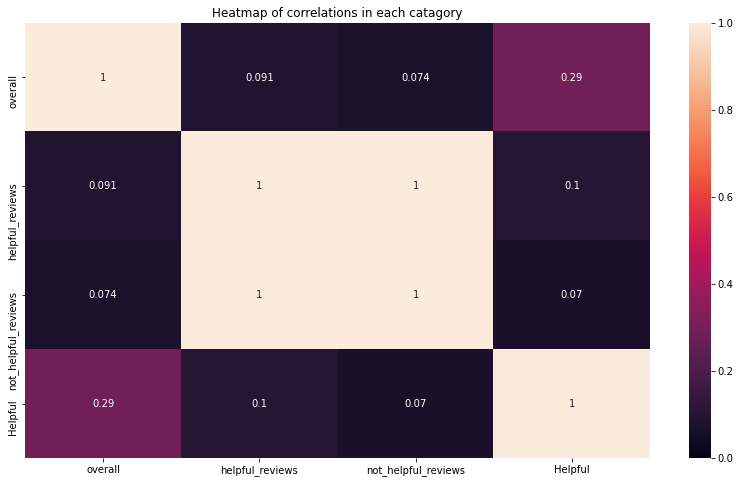

In [12]:
#Visualize correlation of the data
FIG_SIZE = (14,8)

correlations = df1.corr()
plt.figure(figsize = FIG_SIZE)
plt.title("Heatmap of correlations in each catagory")
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)

Theres a slight corellation between overall and helpful rating

## Text Feature Generation using NLP

We converted the text to lower case so we can use natural language processing to produce features. We also removed all the punctuations. All these steps are done to remove the noise.

In [13]:
# convert text to lowercase
df1.loc[:, 'reviewText'] = df1['reviewText'].str.lower()
df.loc[:, 'reviewText'] = df['reviewText'].str.lower()


"""def remove_punctuation(text):
    return text.translate(None, string.punctuation.translate(None,''))"""

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df1['reviewText']=df1['reviewText'].apply(lambda x: remove_punctuation(x))
df1['reviewText'].head(4)


33     i did the 7day trial and was impressed but am ...
94     this app is great  it has a daily verse a dail...
284    this app simply latches on to google maps and ...
288    unable to move to sd card uninstalled cannot r...
Name: reviewText, dtype: object

For each of the stemmed and tolkenized words and ngrams, we will calculate TF-IDF scores.

In [14]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

#create a stemmer
stemmer = SnowballStemmer("english")


#define our own tokenizing function that we will pass into the TFIDFVectorizer. We will also stem the words here.
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems

#loads pickle if exists, extracts and pickles if it doesn't
if os.path.exists('features.pickle'):
    print ('Pickled file already present, loading...')
    features = pickle.load( open( "features.pickle", "rb" ) )
    print ('Pickle file loaded.')
else:
    print("else")
    #define the vectorizer
    vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01)
    #fit the vectorizers to the data.
    features = vectorizer.fit_transform(df1['reviewText'])
features

else


<47932x446 sparse matrix of type '<class 'numpy.float64'>'
	with 727300 stored elements in Compressed Sparse Row format>

## Modeling

We'll look at five models from sklearn library
  
Train and test split is done in 80:20

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,df1['Helpful'], test_size=0.2, random_state=42)

The code below sets up a few functions that will be used to test the models later.

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on roc_auc score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    probas = clf.predict_proba(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return roc_auc_score(target.values, probas[:,1].T)

def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on roc_auc score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, X_train.shape[0]))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("ROC_AUC score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("ROC_AUC score for test set: {:.4f}.\n".format(predict_labels(clf, X_test, y_test)))
    
def clf_test_roc_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    probas = probas =clf.predict_proba(X_test)
    return roc_auc_score(y_test, probas[:,1].T)


Now testing our classifiers. We will put all the results in a table , and will anlyse the top three. We'll train and evaluate the models on three different training sizes to see which one is the best size.

In [17]:
# Import the supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# Initialize the models using a random state were applicable.
clf_list = [GaussianNB(), 
            AdaBoostClassifier(random_state = 42), 
            RandomForestClassifier(random_state = 42), 
            LogisticRegression(random_state = 42),
            DecisionTreeClassifier(random_state = 42)]
x_tr = X_train.toarray()
x_te = X_test.toarray()


# Set up the training set sizes for 100, 200 and 300 respectively.
train_feature_list = [x_tr[0:10000],x_tr[0:20000],x_tr]
train_target_list = [y_train[0:10000], y_train[0:20000], y_train]


# Execute the 'train_predict' function for each of the classifiers and each training set size
for clf in clf_list:
    for a, b in zip(train_feature_list, train_target_list):
        train_predict(clf, a, b, x_te, y_test)

Training a GaussianNB using a training set size of 10000. . .
Trained model in 0.0919 seconds
Made predictions in 0.1319 seconds.
ROC_AUC score for training set: 0.7553.
Made predictions in 0.1249 seconds.
ROC_AUC score for test set: 0.6498.

Training a GaussianNB using a training set size of 20000. . .
Trained model in 0.1809 seconds
Made predictions in 0.2479 seconds.
ROC_AUC score for training set: 0.7310.
Made predictions in 0.1149 seconds.
ROC_AUC score for test set: 0.6742.

Training a GaussianNB using a training set size of 38345. . .
Trained model in 0.4148 seconds
Made predictions in 0.4737 seconds.
ROC_AUC score for training set: 0.7159.
Made predictions in 0.1119 seconds.
ROC_AUC score for test set: 0.6766.

Training a AdaBoostClassifier using a training set size of 10000. . .
Trained model in 6.9326 seconds
Made predictions in 0.9125 seconds.
ROC_AUC score for training set: 0.7604.
Made predictions in 0.9105 seconds.
ROC_AUC score for test set: 0.6852.

Training a AdaBoostC

it appears that the Logistic Regression classifier performed the best and the speed is also decent.

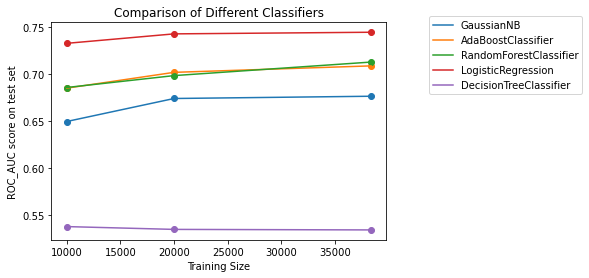

<Figure size 432x288 with 0 Axes>

In [18]:
### Visualize all of the classifiers                                                               

for clf in clf_list:
    x_graph = []
    y_graph = []
    for a, b in zip(train_feature_list, train_target_list):
        y_graph.append(clf_test_roc_score(clf, a, b, x_te, y_test))
        x_graph.append(len(a))
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure()             
plt.show()


In terms of accuracy, Logistic Regression is the best model for all test sizes. It had a sample size of 38,000 and a final score of 0.7448 for the area under the ROC curve. Moreover, for Random Forest and Decision tree, there seems case of overfitting

## Refinement

We're going to try adding a new feature 'overall' to our feature set to see if we can improve our outcomes. 

In [19]:
#add Score column to features
import scipy as scipy

# features = pickle.load( open( pickle_file_name, "rb" ) )
overall = np.array(list(df1.overall))
overall = overall.reshape(features.shape[0], 1)

features = scipy.sparse.hstack((features,scipy.sparse.csr_matrix(overall)))

features = scipy.sparse.csr_matrix(features)
features

<47932x447 sparse matrix of type '<class 'numpy.float64'>'
	with 775232 stored elements in Compressed Sparse Row format>

In [20]:
X_train2, X_test2, y_train, y_test = train_test_split(features, df1['Helpful'], test_size=0.2, random_state=42)


## Grid Search

TWe used grid search to generate a grid of all possible parameters combinations. It is used to find the best parameters for training the model.

In [21]:
import sklearn

In [22]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
#make the grid search object

gs2 = sklearn.model_selection.GridSearchCV(
    estimator = LogisticRegression(),
    param_grid = {'C': [10**i for i in range(-5,5)], 'class_weight': [None, 'balanced']},
    scoring = 'roc_auc'
)

#fit the grid search object to our new dataset
print ('Fitting grid search...')
gs2.fit(X_train2, y_train)
print ("Grid search fitted.")

Fitting grid search...
Grid search fitted.


In [23]:
#print the grid search scores.
print (gs2.best_estimator_)
gs2.cv_results_

LogisticRegression(C=1)


{'mean_fit_time': array([0.08014989, 0.06835575, 0.08055367, 0.07455549, 0.08115196,
        0.11853514, 0.13532667, 0.19109306, 0.35639367, 0.39338207,
        0.53928881, 0.53589191, 0.53189106, 0.5444943 , 0.5442904 ,
        0.52550588, 0.52949362, 0.52528548, 0.52130799, 0.52350421]),
 'std_fit_time': array([0.0085653 , 0.00135253, 0.0033759 , 0.00185007, 0.00890102,
        0.00102883, 0.01217976, 0.00248312, 0.05613124, 0.03767446,
        0.00900128, 0.00843863, 0.00782538, 0.01194823, 0.01110111,
        0.00809   , 0.01235675, 0.01101508, 0.00722246, 0.01031483]),
 'mean_score_time': array([0.0050015 , 0.00439749, 0.00459709, 0.00419931, 0.00419831,
        0.00399394, 0.00419259, 0.00399442, 0.00419536, 0.0039937 ,
        0.00419426, 0.00439782, 0.00460114, 0.0043941 , 0.00439434,
        0.00398946, 0.00419917, 0.00480547, 0.00399346, 0.0043879 ]),
 'std_score_time': array([6.37969831e-04, 4.96188499e-04, 4.94718048e-04, 7.52241930e-04,
        4.08652171e-04, 1.42576702e-

ROC_AUC Score: 0.7796199178113907


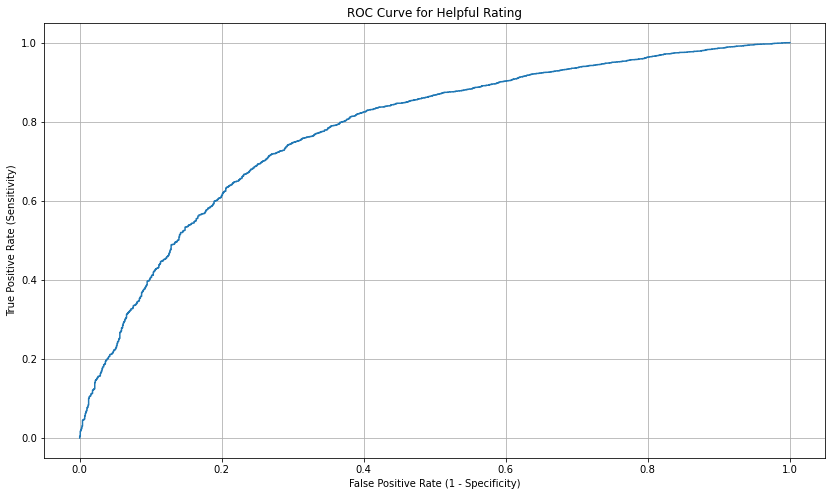

In [24]:
clf2 = gs2.best_estimator_
probas =clf2.predict_proba(X_test2)

plt.figure(figsize = FIG_SIZE)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show

# ROC/AUC score
print ('ROC_AUC Score:',roc_auc_score(y_test, probas[:,1].T))

## Results

## Model Evaluation and Validation

To validate the model, we can look at a number of variables. Setting the min df to 0.01, which required the terms to appear in the documents at least 1% of the time, dramatically reduced the size of our feature space.

Another variable worth investigating is the Logistic Regression algorithm's random state variable. The seed of the pseudo random number generator to utilise when shuffling the data is controlled by the random state variable for the Logistic Regression algorithm.

In [25]:
random_numbers = range(1,101)
tot = 0.0
for seed in random_numbers:
    clf3 = LogisticRegression(random_state=seed)
    clf3.fit(X_train2, y_train)
    probas =clf3.predict_proba(X_test2)
    tot += roc_auc_score(y_test, probas[:,1].T)
    
print ('Average ROC_AUC Score for 1-100 random_state: {:.4f}'.format(tot/100))

Average ROC_AUC Score for 1-100 random_state: 0.7796


For 100 different random states, the average ROC AUC score is 0.7795, which is the same as our optimum solution. Our solution can be considered reliable in this regard.

## Conclusion

Our final improved model got a score of 0.77 under the ROC curve. Compared to the model without improvement, we got a score of scoring 0.74; this is a 3% improvement. This is only based on the addition of one new feature 'overall', so it's quite efficient for the model. 